In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 
import stanza
# Make sure you have downloaded the StanfordNLP English model and other essential tools using,
# stanza.download('en')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# ignore warning
import warnings
warnings.filterwarnings('ignore')

/Users/re378/anaconda3/envs/news1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
# Load articles

In [2]:
import pandas as pd
import json

path = "../Data/"
file_names = ["1Jan2013-31Dec2017.json", "1Jan2018-4Feb2021.json", "5Feb2021-9Mar2023.json"]

articles_df = pd.DataFrame()
for file_name in file_names:
    with open(path + file_name, "r") as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    # concat df
    articles_df = pd.concat([articles_df, df], axis=0)

articles_df.reset_index(drop=True, inplace=True)
drug_names = pd.read_csv("./data/drug_names.csv")
import re
# concatenate name and commercial name
drugs = drug_names["Name"] + ", " + drug_names["Commercial Names"]
drugs = drugs.apply(lambda x: re.sub(r"[\([{'})\]]", "", x))

# remove No commercial uses
not_drugs = ["No commercial uses", "No commercial names", "Various brand names", "is being researched as therapy for Post Traumatic Stress Disorder PTSD under strict medical supervision.",
             'names include "DM"', "Alcohol", "Sleep Medications", "Over-the-Counter Medicines",
             "an OTC medication for diarrhea", "Imodium", "being researched as therapy for treatment-resistant depression under strict medical supervision.",
             'No commercial uses for ingested "bath salts." No relation to “Epsom salt,” sold as a bath product.', "Tobacco", 
             "Nicotine", "Vaping", "Multiple brand names", "Crack", "Speed", "Spice", "Pot", "Molly", "Crystal", "Sonata", "Coke", "Anabolic"]
drugs = drugs.apply(lambda x: x.split(", "))
# drugs = [drug for drug in drugs if drug not in not_drugs]
real_drugs = []
for row in drugs:
    for thing in row:
        if thing not in not_drugs:
            real_drugs.append(thing)

# to lower
missing_drugs = ["suboxone", "naltrexone", "buprenorphine", "oxy", "narcan", "naloxone"]
real_drugs = [drug.lower() for drug in real_drugs]
# add missing drugs
real_drugs.extend(missing_drugs)
real_drugs = list(set(real_drugs))

real_drugs.remove("acid")
real_drugs.remove("bath salts")

# drop 2023
articles_df["Date"] = pd.to_datetime(articles_df["Date"])
articles_df = articles_df[articles_df["Date"].dt.year != 2023]

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import contractions

nlp = spacy.load('en_core_web_md', exclude=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])

def preprocess(text):
    # lower case
    text = text.lower()
    # remove contractions
    text = contractions.fix(text)
    # remove urls
    text = re.sub(r"http\S+", "", text)
    # tokenize
    text = text.split()
    # remove stop words
    text = [token for token in text if token not in STOP_WORDS]

    return text

articles_df["clean_text"] = articles_df["Text"].apply(lambda x: preprocess(x))
sample = "this sentence contains the word narcotic and the word methamphetamine and oxy"
[x for x in sample.split() if x in real_drugs]

drug_articles = pd.DataFrame()

for i, row in articles_df.iterrows():
    if any([x in row["clean_text"] for x in real_drugs]):
        # code is working correctly for the word "weed". the condition "weeds" in "weed" will return false, so nothing to worry about
        matches = [x for x in row["clean_text"] if x in real_drugs]
        if "weed" in matches:
            if "weed out" in row["Text"]:
                matches.remove("weed")
            elif "weed killer" in row["Text"]:
                matches.remove("weed")
        if len(matches) == 0:
            continue
        row["matches"] = matches
        drug_articles = drug_articles.append(row)

drug_articles["drug_mentions"] = drug_articles["matches"].apply(lambda x: len(x))

# make drug classes: DEA
stimulants = ["cocaine", "methamphetamine", "amphetamine", "speed", "meth", "crystal meth", "adderall", "vyvanse", "ritalin", "dexedrine", "desoxyn", "coke"]
hallucinogens = ["hallucinogens","mdma", "lsd", "ecstasy", "peyote", "mescaline", "mushrooms", "dmt", "ayahuasca", "ketamine", "nitrous", "psilocybin", "pcp", "angel dust", "ketalar", "spravato", "esketamine", "ketaset", "acid", "shrooms"]
depressants = ["barbiturates", "benzodiazepines", "xanax", "valium", "benzos","pentobarbital","nembutal","alprazolam","chlorodiazepoxide","librium","diazepam","valium","lorazepam","ativan","triazolam","halicon","sleep medications","eszopiclone","lunesta","zaleplon","sonata","zolpidem","ambien",
"ghb", "gamma-hydroxybutyric acid", "rohypnol", "flunitrazepam", "sonata", "sodium oxybate", "xyrem"]
narcotics = ["opioids", "heroin", "opiate", "fentanyl", "hydromorphone", "hydrocodone", "oxycodone", "codeine", "morphine", "dilaudid", "percocet", "vicodin", "oxycontin", "actiq", "duragesic", "sublimaze","dihydrocodeinone", "norco", "zohydro","meperidine", "demerol", "morphine duramorph", "MS Contin","percodan", "oxymorphone", "opana", "percs"]
treatment = ["naloxone", "naltrexone", "methadone", "buprenorphine", "suboxone", "subutex", "antabuse", "acamprosate", "naltrexone", "disulfiram", "methadose", "dolophine", "narcan"]
designer_drugs = ["bath salts", "flakka", "k2", "spice", "u-47700", "synthetic cannabinoids", "synthetic cathinones"]
cannabis = ["cannabis", "marijuana", "weed", "thc"]
drugs_of_concern = ["kratom", "salvia", "dxm", "dextromethorphan", "salvia divinorum"]

# create drug class column
drug_articles["class_drug"] = ""
drug_articles["drug_class"] = ""
for i,row in enumerate( drug_articles["matches"]):
    class_drug = []
    for drug in row:
        if drug in stimulants:
            # add key and value to dictionary
            # drug_classes["stimulants"] = drug
            a = ("stimulants", drug)
            class_drug.append(a)
        elif drug in hallucinogens:
            a = ("hallucinogens", drug)
            class_drug.append(a)
        elif drug in depressants:
            a = ("depressants", drug)
            class_drug.append(a)
        elif drug in narcotics:
            a = ("narcotics", drug)
            class_drug.append(a)
        elif drug in treatment:
            a = ("treatment", drug)
            class_drug.append(a)
        elif drug in designer_drugs:
            a = ("designer_drugs", drug)
            class_drug.append(a)
        elif drug in cannabis:
            a = ("cannabis", drug)
            class_drug.append(a)
        elif drug in drugs_of_concern:
            a = ("drugs_of_concern", drug)
            class_drug.append(a)
        else:
            a = ("miscellaneous", drug)
            class_drug.append(a)
    class_drug = list(set(class_drug))
    drug_articles["class_drug"].iloc[i] = class_drug
    drug_articles["drug_class"].iloc[i] = [x[0] for x in class_drug]
print(len(drug_articles))

3661


In [3]:
drug_articles_stimulants = drug_articles[pd.DataFrame(drug_articles.drug_class.tolist()).isin(['stimulants']).any(1).values]
drug_articles_cannabis = drug_articles[pd.DataFrame(drug_articles.drug_class.tolist()).isin(['cannabis']).any(1).values]
drug_articles_depressants = drug_articles[pd.DataFrame(drug_articles.drug_class.tolist()).isin(['depressants']).any(1).values]
drug_articles_treatment = drug_articles[pd.DataFrame(drug_articles.drug_class.tolist()).isin(['treatment']).any(1).values]
drug_articles_narcotics = drug_articles[pd.DataFrame(drug_articles.drug_class.tolist()).isin(['narcotics']).any(1).values]
drug_articles_hallucinogens = drug_articles[pd.DataFrame(drug_articles.drug_class.tolist()).isin(['hallucinogens']).any(1).values]

In [6]:
drug_articles_cannabis

Title  \
169     Boy, 14, pleads no contest in Bucks: He was ac...   
292     Drugs not the issue; illicit trade is: Legaliz...   
545     $3.5M for 87 in police fraud: Settlement is re...   
573                   SideShow: YOUR DAILY DOSE OF GOSSIP   
644     Bucks woman charged in fatal crash with motorc...   
...                                                   ...   
157091  Brittney Griner’s long journey home: The baske...   
157110  Dirty cop's case is in doubt: One man was lock...   
157176  Brittney Griner is home, but my brother is sti...   
157348  How John Fetterman will fit in the U.S. Senate...   
157372  16 years for key figure in Mich. abduction plo...   

                                      Writer       Date  \
169                        Moran, Robert. \n 2013-01-04   
292                        Prince, Erich. \n 2013-01-06   
545                        Simon, Darran. \n 2013-01-10   
573                  Derakhshani, Tirdad. \n 2013-01-10   
644                       Matza, Michael. \n 2013-01-11   
...                                      ...        ...   
157091                    Jones, Solomon. \n 2022-12-18   
157110                 Melamed, Samantha. \n 2022-12-19   
157176                      Hyland, Lisa. \n 2022-12-21   
157348  Terruso, Julia; Tamari, Jonathan. \n 2022-12-27   
157372            Kara Berg Detroit News. \n 2022-12-28   

                                                  Details  \
169     /docview/1266912057/fulltext/51A554B063CD4A42P...   
292     /docview/1267154302/fulltext/902C6FE8E5E047BEP...   
545     /docview/1268758730/fulltext/3F355DEAA6C5483DP...   
573     /docview/1268758723/fulltext/3F355DEAA6C5483DP...   
644     /docview/1268849360/fulltext/EBDB690AFE6D4BC2P...   
...                                                   ...   
157091  /docview/2755242580/citation/4F23413ED60042DDP...   
157110  /docview/2755489189/citation/41CDB37B1ACF4BBFP...   
157176  /docview/2756065743/citation/15096505CF6D419CP...   
157348  /docview/2758258709/citation/70049B0E29374433P...   
157372  /docview/2758530781/citation/65905883326E46E4P...   

                                                     Text  \
169     \n\n \n\nThe 14-year-old boy accused of threat...   
292     \n\n \n\nIn 1991, Milton Friedman appeared on ...   
545     \n\n \n\nA $3.5 million settlement has been re...   
573     \n\n \n\nSinging out for Obama\n\n\nPresident ...   
644     \n\n \n\nA Bucks County woman with a history o...   
...                                                   ...   
157091  When Brittney Griner was returned to America i...   
157110  Milique Wagner was exhausted and bleary-eyed a...   
157176  I was relieved to hear that basketball star Br...   
157348  For close to two years, John Fetterman was a p...   
157372  GRAND RAPIDS, Mich. — One of two ringleaders i...   

                                               clean_text  \
169     [14-year-old, boy, accused, threatening, shoot...   
292     [1991,, milton, friedman, appeared, television...   
545     [$3.5, million, settlement, reached, federal, ...   
573     [singing, obama, president, obama's, january, ...   
644     [bucks, county, woman, history, impaired, driv...   
...                                                   ...   
157091  [brittney, griner, returned, america, prisoner...   
157110  [milique, wagner, exhausted, bleary-eyed, days...   
157176  [relieved, hear, basketball, star, brittney, g...   
157348  [close, years,, john, fetterman, political, ce...   
157372  [grand, rapids,, mich., —, ringleaders, plot, ...   

                                 matches  drug_mentions  \
169                          [marijuana]              1   
292                  [heroin, marijuana]              2   
545                          [marijuana]              1   
573                           [cannabis]              1   
644               [marijuana, marijuana]              2   
...                                  ...            ...  

In [4]:
cannabis_articles = drug_articles_cannabis['Text'].tolist()
cannabis_articles_dates = drug_articles_cannabis['Date'].tolist()

stimulants_articles = drug_articles_stimulants['Text'].tolist()
stimulants_articles_dates = drug_articles_stimulants['Date'].tolist()

depressants_articles = drug_articles_depressants['Text'].tolist()
depressants_articles_dates = drug_articles_depressants['Date'].tolist()

treatment_articles = drug_articles_treatment['Text'].tolist()
treatment_articles_dates = drug_articles_treatment['Date'].tolist()

narcotics_articles = drug_articles_narcotics['Text'].tolist()
narcotics_articles_dates = drug_articles_narcotics['Date'].tolist()

hallucinogens_articles = drug_articles_hallucinogens['Text'].tolist()
hallucinogens_articles_dates = drug_articles_hallucinogens['Date'].tolist()


In [9]:
len(hallucinogens_articles)

137

---
# Testing code (skip to next part)

In [8]:
import re
from collections import defaultdict


def aspect_sentiment_analysis(txt, stop_words, nlp, drug):
    
    txt = txt.lower() # LowerCasing the given Text
    sentList = nltk.sent_tokenize(txt) # Splitting the text into sentences

    fcluster = []
    totalfeatureList = []
    finalcluster = []
    dic = {}
    num = 0
    for line in sentList:
        if drug not in line:
            continue

        # print(line)
        line = line.replace('-', ' ')
        line = line.replace('/', ' ')
        line = line.replace('\\', ' ')
        line = line.replace('"', '')
        line = line.replace("'", '')
        line = re.sub(r'[^\w\s]', '', line)
        line = line + '.'

        newtaggedList = []
        txt_list = nltk.word_tokenize(line) # Splitting up into words
        taggedList = nltk.pos_tag(txt_list) # Doing Part-of-Speech Tagging to each word

        newwordList = []
        flag = 0
        for i in range(0,len(taggedList)-1):
            if(taggedList[i][1]=="NN" and taggedList[i+1][1]=="NN"): # If two consecutive words are Nouns then they are joined together
                newwordList.append(taggedList[i][0]+taggedList[i+1][0])
                flag=1
            else:
                if(flag==1):
                    flag=0
                    continue
                newwordList.append(taggedList[i][0])
                if(i==len(taggedList)-2):
                    newwordList.append(taggedList[i+1][0])

        finaltxt = ' '.join(word for word in newwordList) 
        new_txt_list = nltk.word_tokenize(finaltxt)
        wordsList = [w for w in new_txt_list if not w in stop_words]
        taggedList = nltk.pos_tag(wordsList)

        doc = nlp(finaltxt) # Object of Stanford NLP Pipeleine
        if len(doc.sentences) == 0:
            continue
        # Getting the dependency relations betwwen the words
        dep_node = []
        for dep_edge in doc.sentences[0].dependencies:
            dep_node.append([dep_edge[2].text, dep_edge[0].id, dep_edge[1]])
        
        # print(dep_node)
        # print(newwordList)
        # Coverting it into appropriate format
        flag = False
        for i in range(0, len(dep_node)):
            if (int(dep_node[i][1]) != 0):
                b = (int(dep_node[i][1]) - 1)
                # if b == len(newwordList):
                #     b = b-1
                # print(len(newwordList),b)
                if (b >= len(newwordList)):
                    flag = True
                    break
                a = newwordList[b]
                dep_node[i][1] = a
        if flag:
            continue
        featureList = []
        categories = []
        for i in taggedList:
            if(i[1]=='JJ' or i[1]=='NN' or i[1]=='JJR' or i[1]=='NNS' or i[1]=='RB'):
                featureList.append(list(i)) # For features for each sentence
                totalfeatureList.append(list(i)) # Stores the features of all the sentences in the text
                categories.append(i[0])

        for i in featureList:
            filist = []
            for j in dep_node:
                if((j[0]==i[0] or j[1]==i[0]) and (j[2] in ["nsubj", "acl:relcl", "obj", "dobj", "agent", "advmod", "amod", "neg", "prep_of", "acomp", "xcomp", "compound"])):
                    if(j[0]==i[0]):
                        filist.append(j[1])
                    else:
                        filist.append(j[0])
            fcluster.append([i[0], filist])
            
    for i in totalfeatureList:
        dic[i[0]] = i[1]
    
    for i in fcluster:
        if(dic[i[0]]=="NN"):
            finalcluster.append(i)
        
    return(finalcluster)

nlp = stanza.Pipeline('en')
stop_words = set(stopwords.words('english'))
txt = "The Sound Quality is great but the battery life is very bad."

clusters_marijuana = defaultdict(list)
num = 0
for art in cannabis_articles:
    date = cannabis_articles_dates[num]
    c = aspect_sentiment_analysis(art, stop_words, nlp, 'marijuana')
    clusters_marijuana[date].append(c)
    num = num + 1
    if num % 10 == 0:
        print("Getting there " + str(num) + '/' + str(len(cannabis_articles)))
# print(aspect_sentiment_analysis(text, stop_words, nlp))

2023-07-11 10:13:09 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-07-11 10:13:12 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| constituency | wsj       |
| depparse     | combined  |
| sentiment    | sstplus   |
| ner          | ontonotes |

2023-07-11 10:13:12 INFO: Using device: cpu
2023-07-11 10:13:12 INFO: Loading: tokenize
2023-07-11 10:13:12 INFO: Loading: pos
2023-07-11 10:13:12 INFO: Loading: lemma
2023-07-11 10:13:12 INFO: Loading: constituency
2023-07-11 10:13:12 INFO: Loading: depparse
2023-07-11 10:13:12 INFO: Loading: sentiment
2023-07-11 10:13:13 INFO: Loading: ner
2023-07-11 10:13:13 INFO: Done loading processors!
[W NNPACK.cpp:64] Could not initialize NNPACK! Reason:

Getting there 10/1637
Getting there 20/1637
Getting there 30/1637
Getting there 40/1637
Getting there 50/1637
Getting there 60/1637
Getting there 70/1637
Getting there 80/1637
Getting there 90/1637
Getting there 100/1637
Getting there 110/1637
Getting there 120/1637
Getting there 130/1637
Getting there 140/1637
Getting there 150/1637
Getting there 160/1637
Getting there 170/1637
Getting there 180/1637
Getting there 190/1637
Getting there 200/1637
Getting there 210/1637
Getting there 220/1637
Getting there 230/1637
Getting there 240/1637
Getting there 250/1637
Getting there 260/1637
Getting there 270/1637
Getting there 280/1637
Getting there 290/1637
Getting there 300/1637
Getting there 310/1637
Getting there 320/1637
Getting there 330/1637
Getting there 340/1637
Getting there 350/1637
Getting there 360/1637
Getting there 370/1637
Getting there 380/1637
Getting there 390/1637
Getting there 400/1637
Getting there 410/1637
Getting there 420/1637
Getting there 430/1637
Getting there 440/16

In [25]:
marijuana_aspects = defaultdict(list)
keys = list(clusters_marijuana.keys())
for key in keys:
    year = str(key).split("-")[0]
    for article in clusters_marijuana[key]:
        for terms in article:
            for innerTerms in terms:
                if 'marijuana' in innerTerms:
                    marijuana_aspects[year].append(terms)
                    continue
print(marijuana_aspects)

defaultdict(<class 'list'>, {'2013': [['marijuana', []], ['marijuanablunt', ['sedatives']], ['marijuana', ['smoked']], ['marijuana', []], ['grademarijuana', ['high']], ['marijuanapot', ['grass']], ['marijuana', []], ['marijuana', ['laws']], ['marijuanabill', ['gained']], ['marijuana', ['legalizing']], ['marijuana', ['smoking']], ['marijuana', ['medical', 'have']], ['marijuana', ['regulating']], ['marijuana', ['legalize']], ['marijuanatrafficking', []], ['marijuana', ['legalizing']], ['marijuana', ['having']], ['marijuana', ['smoking']], ['marijuana', []], ['use', ['marijuana']], ['use', ['marijuana']], ['distribute', ['marijuana']], ['dispensary', ['nonprofit', 'marijuana']], ['possession', ['marijuana']], ['marijuana', ['patients']], ['act', ['new', 'jerseys', 'medical', 'marijuana', 'became']], ['marijuana', ['regulations']], ['marijuana', ['medical', 'obtain']], ['marijuana', []], ['marijuana', ['programs']], ['marijuana', ['medical']], ['marijuanaprogram', ['programthursday']], ['m

In [123]:
# marijuana_aspects = []
# for article in clusters_marijuana:
#     for terms in article:
#         # if 'marijuana' in terms:
#         for innerTerms in terms:
#             if 'marijuana' in innerTerms:
#                 marijuana_aspects.append(terms)
#                 continue
# print(marijuana_aspects)

[['marijuana', []], ['marijuanablunt', ['sedatives']], ['marijuana', ['smoked']], ['marijuana', []], ['grademarijuana', ['high']], ['marijuanapot', ['grass']], ['marijuana', []], ['marijuana', ['laws']], ['marijuanabill', ['gained']], ['marijuana', ['legalizing']], ['marijuana', ['smoking']], ['marijuana', ['medical', 'have']], ['marijuana', ['regulating']], ['marijuana', ['legalize']], ['marijuanatrafficking', []], ['marijuana', ['legalizing']], ['marijuana', ['having']], ['marijuana', ['smoking']], ['marijuana', []], ['use', ['marijuana']], ['use', ['marijuana']], ['distribute', ['marijuana']], ['dispensary', ['nonprofit', 'marijuana']], ['possession', ['marijuana']], ['marijuana', ['patients']], ['act', ['new', 'jerseys', 'medical', 'marijuana', 'became']], ['marijuana', ['regulations']], ['marijuana', ['medical', 'obtain']], ['marijuana', []], ['marijuana', ['programs']], ['marijuana', ['medical']], ['marijuanaprogram', ['programthursday']], ['marijuana', ['contended']], ['marijuan

In [32]:
aspects = defaultdict(list)
keys = list(marijuana_aspects.keys())
for key in keys:
    for l in marijuana_aspects[key]:
        for item in l:
            if isinstance(item, list):
                for term in item:
                    if 'marijuana' in term:
                        term = term.replace('marijuana', '')
                    if term == '':
                        continue
                    aspects[key].append(term)
            else:
                if 'marijuana' in item:
                    item = item.replace('marijuana', '')
                if item == '':
                    continue
                aspects[key].append(item)
print(aspects['2018'])
# print(keys)

['medical', 'medical', 'patient', 'medical', 'program', 'medical', 'legalized', 'patients', 'possession', 'program', 'joining', 'legalized', 'policy', 'policyproject', 'patients', 'card', 'carddansky', 'program', 'medical', 'had', 'purchase', 'legalized', 'medical', 'legalized', 'laws', 'enforcement', 'enforcement', 'law', 'federal', 'enforce', 'legal', 'legal', 'industry', 'industry', 'burgeoning', 'banned', 'legalized', 'programs', 'medical', 'prescribed', 'trade', 'control', 'laws', 'advocates', 'patients', 'medical', 'therapy', 'therapy', 'potential', 'mitigate', 'patients', 'schedule', 'schedule', 'move', 'prosecutions', 'use', 'medical', 'use', 'use', 'recreational', 'cover', 'medical', 'policies', 'medical', 'use', 'legalized', 'use', 'unauthorized', 'medical', 'protect', 'use', 'legalize', 'prosecutions', 'businesses', 'businesses', 'policy', 'cover', 'recreational', 'cover', 'legalized', 'use', 'use', 'medical', 'prosecuting', 'permitted', 'reschedule', 'businesses', 'recreati

In [124]:
# aspects = []
# for l in marijuana_aspects:
#     for item in l:
#         if isinstance(item, list):
#             for term in item:
#                 if 'marijuana' in term:
#                     term = term.replace('marijuana', '')
#                 if term == '':
#                     continue
#                 aspects.append(term)
#         else:
#             if 'marijuana' in item:
#                 item = item.replace('marijuana', '')
#             if item == '':
#                 continue
#             aspects.append(item)
# print(aspects)

['blunt', 'sedatives', 'smoked', 'grade', 'high', 'pot', 'grass', 'laws', 'bill', 'gained', 'legalizing', 'smoking', 'medical', 'have', 'regulating', 'legalize', 'trafficking', 'legalizing', 'having', 'smoking', 'use', 'use', 'distribute', 'dispensary', 'nonprofit', 'possession', 'patients', 'act', 'new', 'jerseys', 'medical', 'became', 'regulations', 'medical', 'obtain', 'programs', 'medical', 'program', 'programthursday', 'contended', 'medical', 'forchion', 'ed', 'predicted', 'calls', 'medical', 'smoked', 'medical', 'smoked', 'planted', 'possession', 'possession', 'role', 'plays', 'took', 'joint', 'trade', 'trade', 'westcoast', 'uses', 'put', 'trying', 'food', 'trying', 'use', 'legalizationactivist', 'used', 'heroin', 'heroin', 'intercepted', 'passed', 'debate', 'medical', 'use', 'medical', 'dispensaries', 'law', 'medical', 'doctor', 'medical', 'included', 'patient', 'get', 'bring', 'bring', 'that', 'reliefwaltz', 'said', 'medical', 'receive', 'alternative', 'medical', 'said', 'had',

In [36]:
keys = list(aspects.keys())
wrd_cld = []
for key in keys:
    for year in aspects[key]:
        wrd_cld.append(year)

In [37]:
len(wrd_cld)

9017

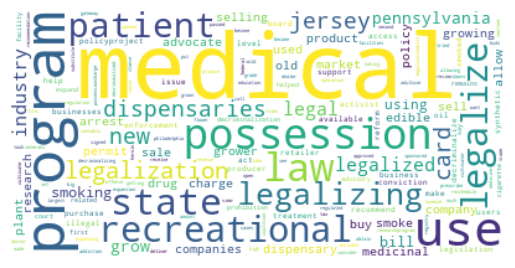

In [38]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
stopwords.update(["said"])
listToStr = ' '.join([str(elem) for elem in wrd_cld])
wordcloud = WordCloud(collocations=False, stopwords=stopwords, background_color="white").generate(listToStr)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

[('medical', 86), ('program', 29), ('use', 14), ('possession', 13), ('court', 12), ('edible', 10), ('dispensary', 9), ('law', 9), ('card', 7), ('patients', 6)]


<BarContainer object of 10 artists>

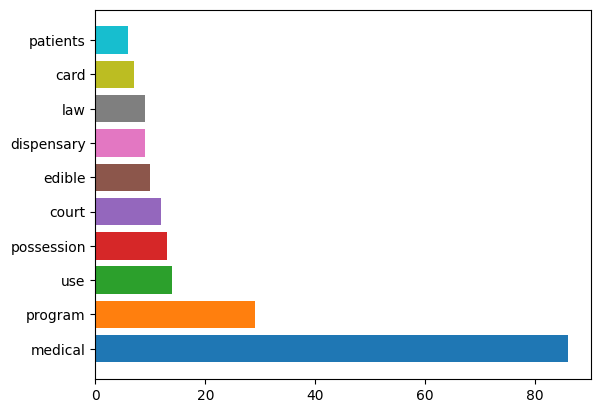

In [71]:
from collections import Counter
import matplotlib.pyplot as plt

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

list1 = aspects['2013']
counts = Counter(list1)
marijuana_2013 = counts.most_common(10)
print(marijuana_2013)

x = [x for x, y in marijuana_2013]
y = [y for x, y in marijuana_2013]
plt.barh(x,y, color=colors)


---
# Get aspects of all drugs using Dependency Parsing (skip to next part, decided to use another method)

In [23]:
cannabis_drugs = ['marijuana', 'cannabis', 'weed']
narcotics_drugs = ["opioids", "heroin", "opiate", "fentanyl", "oxycodone", "hydrocodone", 'percocet', 'oxycontin', 'opana', 'demerol', 'vicodin']
stimulents_drugs = ['cocaine', 'methamphetamine', 'meth', 'adderall', 'amphetamine']
hallucinogens_drugs = ['ecstasy', 'pcp', 'lsd']
treatment_drugs = ['methadone', 'buprenorphine', 'suboxone']
miscellaneous_drugs = ['steroids']
depressants_drugs = ['xanax', 'ambien']

In [60]:
import re
from collections import defaultdict


def aspect_sentiment_analysis(txt, stop_words, nlp, drug):
    
    txt = txt.lower() # LowerCasing the given Text
    sentList = nltk.sent_tokenize(txt) # Splitting the text into sentences

    fcluster = []
    totalfeatureList = []
    finalcluster = []
    dic = {}
    num = 0
    for line in sentList:
        if drug not in line:
            continue
        # print(line)
        line = line.replace('-', ' ')
        line = line.replace('/', ' ')
        line = line.replace('\\', ' ')
        line = line.replace('"', '')
        line = line.replace("'", '')
        line = re.sub(r'[^\w\s]', '', line)
        line = line + '.'

        newtaggedList = []
        txt_list = nltk.word_tokenize(line) # Splitting up into words
        taggedList = nltk.pos_tag(txt_list) # Doing Part-of-Speech Tagging to each word

        newwordList = []
        flag = 0
        for i in range(0,len(taggedList)-1):
            if(taggedList[i][1]=="NN" and taggedList[i+1][1]=="NN"): # If two consecutive words are Nouns then they are joined together
                newwordList.append(taggedList[i][0]+taggedList[i+1][0])
                flag=1
            else:
                if(flag==1):
                    flag=0
                    continue
                newwordList.append(taggedList[i][0])
                if(i==len(taggedList)-2):
                    newwordList.append(taggedList[i+1][0])

        finaltxt = ' '.join(word for word in newwordList) 
        new_txt_list = nltk.word_tokenize(finaltxt)
        wordsList = [w for w in new_txt_list if not w in stop_words]
        taggedList = nltk.pos_tag(wordsList)

        doc = nlp(finaltxt) # Object of Stanford NLP Pipeleine
        if len(doc.sentences) == 0:
            continue
        # Getting the dependency relations betwwen the words
        dep_node = []
        for dep_edge in doc.sentences[0].dependencies:
            dep_node.append([dep_edge[2].text, dep_edge[0].id, dep_edge[1]])
        
        # print(dep_node)
        # print(newwordList)
        # Coverting it into appropriate format
        flag = False
        for i in range(0, len(dep_node)):
            if (int(dep_node[i][1]) != 0):
                b = (int(dep_node[i][1]) - 1)
                # if b == len(newwordList):
                #     b = b-1
                # print(len(newwordList),b)
                if (b >= len(newwordList)):
                    flag = True
                    break
                a = newwordList[b]
                dep_node[i][1] = a
        if flag:
            continue
        featureList = []
        categories = []
        for i in taggedList:
            if(i[1]=='JJ' or i[1]=='NN' or i[1]=='JJR' or i[1]=='NNS' or i[1]=='RB'):
                featureList.append(list(i)) # For features for each sentence
                totalfeatureList.append(list(i)) # Stores the features of all the sentences in the text
                categories.append(i[0])

        for i in featureList:
            filist = []
            for j in dep_node:
                if((j[0]==i[0] or j[1]==i[0]) and (j[2] in ["nsubj", "acl:relcl", "obj", "dobj", "agent", "advmod", "amod", "neg", "prep_of", "acomp", "xcomp", "compound"])):
                    if(j[0]==i[0]):
                        filist.append(j[1])
                    else:
                        filist.append(j[0])
            fcluster.append([i[0], filist])
        # print(fcluster)
    # print(sentList)
    # print(totalfeatureList)
    for i in totalfeatureList:
        dic[i[0]] = i[1]
    
    for i in fcluster:
        if(dic[i[0]]=="NN" or dic[i[0]]=="NNS"):
            finalcluster.append(i)
        
    return(finalcluster)

## Cannabis

In [25]:
import pickle 

nlp = stanza.Pipeline('en')
stop_words = set(stopwords.words('english'))

clusters_ = defaultdict(list)
for drug in cannabis_drugs:
    num = 0
    for art in cannabis_articles:
        date = cannabis_articles_dates[num]
        c = aspect_sentiment_analysis(art, stop_words, nlp, drug)
        clusters_[date].append(c)
        num = num + 1
        if num % 10 == 0:
            print("Getting there " + str(num) + '/' + str(len(cannabis_articles)))

    aspects_ = defaultdict(list)
    keys = list(clusters_.keys())
    for key in keys:
        year = str(key).split("-")[0]
        for article in clusters_[key]:
            for terms in article:
                for innerTerms in terms:
                    if drug in innerTerms:
                        aspects_[year].append(terms)
                        continue
# print(marijuana_aspects)

    aspects = defaultdict(list)
    keys = list(aspects_.keys())
    for key in keys:
        for l in aspects_[key]:
            for item in l:
                if isinstance(item, list):
                    for term in item:
                        if drug in term:
                            term = term.replace(drug, '')
                        if term == '':
                            continue
                        aspects[key].append(term)
                else:
                    if drug in item:
                        item = item.replace(drug, '')
                    if item == '':
                        continue
                    aspects[key].append(item)
# print(aspects['2018'])
# print(keys)

    from collections import Counter
    import matplotlib.pyplot as plt

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    years = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
    with open('./aspects/cannabis/'+drug+'.pkl', 'wb') as f:
        pickle.dump(aspects, f)
    for year in years:
        list1 = aspects[year]
        counts = Counter(list1)
        most_common_aspects = counts.most_common(10)
        # print(most_common_aspects)

        fig = plt.figure()
        x = [x for x, y in most_common_aspects]
        y = [y for x, y in most_common_aspects]
        plt.barh(x,y, color=colors)
        fig.savefig('./aspects/cannabis/'+drug+'_'+year+'.png',dpi=300, bbox_inches = "tight")
        plt.close(fig)


2023-07-19 11:29:49 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-07-19 11:29:51 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| constituency | wsj       |
| depparse     | combined  |
| sentiment    | sstplus   |
| ner          | ontonotes |

2023-07-19 11:29:51 INFO: Using device: cpu
2023-07-19 11:29:51 INFO: Loading: tokenize
2023-07-19 11:29:51 INFO: Loading: pos
2023-07-19 11:29:51 INFO: Loading: lemma
2023-07-19 11:29:51 INFO: Loading: constituency
2023-07-19 11:29:51 INFO: Loading: depparse
2023-07-19 11:29:52 INFO: Loading: sentiment
2023-07-19 11:29:52 INFO: Loading: ner
2023-07-19 11:29:52 INFO: Done loading processors!


Getting there 10/1575
Getting there 20/1575
Getting there 30/1575
Getting there 40/1575
Getting there 50/1575
Getting there 60/1575
Getting there 70/1575
Getting there 80/1575
Getting there 90/1575
Getting there 100/1575
Getting there 110/1575
Getting there 120/1575
Getting there 130/1575
Getting there 140/1575
Getting there 150/1575
Getting there 160/1575
Getting there 170/1575
Getting there 180/1575
Getting there 190/1575
Getting there 200/1575
Getting there 210/1575
Getting there 220/1575
Getting there 230/1575
Getting there 240/1575
Getting there 250/1575
Getting there 260/1575
Getting there 270/1575
Getting there 280/1575
Getting there 290/1575
Getting there 300/1575
Getting there 310/1575
Getting there 320/1575
Getting there 330/1575
Getting there 340/1575
Getting there 350/1575
Getting there 360/1575
Getting there 370/1575
Getting there 380/1575
Getting there 390/1575
Getting there 400/1575
Getting there 410/1575
Getting there 420/1575
Getting there 430/1575
Getting there 440/15

KeyboardInterrupt: 

## Hallucinogens

In [61]:
import pickle 

nlp = stanza.Pipeline('en')
stop_words = set(stopwords.words('english'))

clusters_ = defaultdict(list)
for drug in hallucinogens_drugs:
    num = 0
    for art in hallucinogens_articles:
        date = hallucinogens_articles_dates[num]
        c= aspect_sentiment_analysis(art, stop_words, nlp, drug)
        # print(c)
        
        clusters_[date].append(c)
        num = num + 1
        if num % 10 == 0:
            print("Getting there " + str(num) + '/' + str(len(hallucinogens_articles)))
    aspects_ = defaultdict(list)
    keys = list(clusters_.keys())
    for key in keys:
        year = str(key).split("-")[0]
        for article in clusters_[key]:
            for terms in article:
                for innerTerms in terms:
                    if drug in innerTerms:
                        aspects_[year].append(terms)
                        continue
    # print(aspects_)

    aspects = defaultdict(list)
    keys = list(aspects_.keys())
    for key in keys:
        for l in aspects_[key]:
            for item in l:
                if isinstance(item, list):
                    for term in item:
                        if drug in term:
                            term = term.replace(drug, '')
                        if term == '':
                            continue
                        aspects[key].append(term)
                else:
                    if drug in item:
                        item = item.replace(drug, '')
                    if item == '':
                        continue
                    aspects[key].append(item)
# print(aspects['2018'])
# print(keys)

    from collections import Counter
    import matplotlib.pyplot as plt

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    years = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
            
    with open('./aspects/hallucinogens/'+drug+'.pkl', 'wb') as f:
        pickle.dump(aspects, f)
    for year in years:
        list1 = aspects[year]
        counts = Counter(list1)
        # print(counts)
        most_common_aspects = counts.most_common(10)
        # print(most_common_aspects)

        fig = plt.figure()
        x = [x for x, y in most_common_aspects]
        y = [y for x, y in most_common_aspects]
        plt.barh(x,y, color=colors)
        fig.savefig('./aspects/hallucinogens/'+drug+'_'+year+'.png',dpi=300, bbox_inches = "tight")
        plt.close(fig)

2023-07-20 10:36:29 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-07-20 10:36:31 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| constituency | wsj       |
| depparse     | combined  |
| sentiment    | sstplus   |
| ner          | ontonotes |

2023-07-20 10:36:31 INFO: Using device: cpu
2023-07-20 10:36:31 INFO: Loading: tokenize
2023-07-20 10:36:31 INFO: Loading: pos
2023-07-20 10:36:31 INFO: Loading: lemma
2023-07-20 10:36:31 INFO: Loading: constituency
2023-07-20 10:36:32 INFO: Loading: depparse
2023-07-20 10:36:32 INFO: Loading: sentiment
2023-07-20 10:36:33 INFO: Loading: ner
2023-07-20 10:36:33 INFO: Done loading processors!


Getting there 10/137
Getting there 20/137
Getting there 30/137
Getting there 40/137
Getting there 50/137
Getting there 60/137
Getting there 70/137
Getting there 80/137
Getting there 90/137
Getting there 100/137
Getting there 110/137
Getting there 120/137
Getting there 130/137
Getting there 10/137
Getting there 20/137
Getting there 30/137
Getting there 40/137
Getting there 50/137
Getting there 60/137
Getting there 70/137
Getting there 80/137
Getting there 90/137
Getting there 100/137
Getting there 110/137
Getting there 120/137
Getting there 130/137
Getting there 10/137
Getting there 20/137
Getting there 30/137
Getting there 40/137
Getting there 50/137
Getting there 60/137
Getting there 70/137
Getting there 80/137
Getting there 90/137
Getting there 100/137
Getting there 110/137
Getting there 120/137
Getting there 130/137


In [50]:
from transformers import pipeline

pipe = pipeline("text-classification", model="deberta/deberta-v3-base-absa-v1.1")

In [71]:
with open('aspects/hallucinogens/lsd.pkl', 'rb') as f:
    lsd_aspects = pickle.load(f)
with open('aspects/hallucinogens/pcp.pkl', 'rb') as f:
    pcp_aspects = pickle.load(f)
with open('aspects/hallucinogens/ecstasy.pkl', 'rb') as f:
    ecstasy_aspects = pickle.load(f)

h_aspects = {
    'lsd':lsd_aspects,
    'pcp':pcp_aspects,
    'ecstasy':ecstasy_aspects
}
fc = {}
for drug in hallucinogens_drugs:
    num = 0
    sents = defaultdict(list)
    for art in hallucinogens_articles:
        date = hallucinogens_articles_dates[num]
        num += 1
        art = art.lower() # LowerCasing the given Text
        sentList = nltk.sent_tokenize(art) # Splitting the text into sentences
        for line in sentList:
            if drug in line:
                line = "[CLS] " + line + " [SEP] " + drug + " [SEP]"
                sents[str(date).split("-")[0]].append(line)
    # print(sents)
    years = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
    sentiments = {}
    for year in years:
        list1 = h_aspects[drug][year]
        list1 = [*set(list1)]
        sentences = sents[year]
        for aspect in list1:
            # if aspect == 'bletchleycircle':
            #     aspect = 'bletchley circle'
            # elif aspect == 'horrorfilm':
            #     aspect = 'horror film'
            # elif aspect == 'skinnykid':
            #     aspect = 'skinny kid'
            # elif aspect == 'jersey attorney':
            #     aspect = 'jersey attorney'
            # elif aspect == 'schiesa':
            #     aspect = 'chiesa'
            scores = []
            for sent in sentences:
                # if 'therapy' in sent:
                #     print(sent + year)
                if aspect in sent:
                    if aspect == 'like':
                        print(sent)
                    scores.append(pipe(sent))
                elif aspect in sent.replace(" ", ""):
                    scores.append(pipe(sent))
            sentiments[aspect+year] = scores
    fc[drug] = sentiments
# for drug in hallucinogens_drugs:
#     print(fc[drug])
fc

[CLS] the synthetic opioid has turned up in stimulants like cocaine and methamphetamine, and hallucinogens like pcp — putting people with no tolerance for opioids at higher risk of an overdose. [SEP] pcp [SEP]
[CLS] “so ketamine and pcplike substances, those are what we’re exploring. [SEP] pcp [SEP]


{'ecstasy': {'prefers2013': [[{'label': 'Positive',
     'score': 0.8428677916526794}]],
  'drugs2013': [[{'label': 'Neutral', 'score': 0.9715059399604797}]],
  'miley2013': [[{'label': 'Neutral', 'score': 0.9686307907104492}]],
  'pure2013': [[{'label': 'Positive', 'score': 0.958634614944458}]],
  'pills2013': [[{'label': 'Neutral', 'score': 0.7791749238967896}],
   [{'label': 'Neutral', 'score': 0.9715059399604797}],
   [{'label': 'Neutral', 'score': 0.9692068099975586}]],
  'bletchleycircle2013': [[{'label': 'Positive', 'score': 0.958634614944458}]],
  'she2013': [[{'label': 'Positive', 'score': 0.8428677916526794}],
   [{'label': 'Neutral', 'score': 0.9760746359825134}],
   [{'label': 'Neutral', 'score': 0.9775830507278442}],
   [{'label': 'Neutral', 'score': 0.9965929388999939}]],
  'weed2013': [[{'label': 'Neutral', 'score': 0.9956515431404114}]],
  'reports2013': [[{'label': 'Neutral', 'score': 0.9692068099975586}]],
  'horrorfilm2014': [[{'label': 'Neutral', 'score': 0.98478227

## 

In [127]:
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
# nltk.download('sentiwordnet')
# nltk.download('wordnet')

# lemma = lemmatizer.lemmatize('')
# synsets = wn.synsets(lemma)
# swn_synset = swn.senti_synset(synsets[0].name())
# print(swn_synset)

sentiment = 0.0
for word in aspects:
    lemma = lemmatizer.lemmatize(word)
    synsets = wn.synsets(lemma)
    if not synsets:
        continue
    swn_synset = swn.senti_synset(synsets[0].name())
    sentiment += swn_synset.pos_score() - swn_synset.neg_score()

print(sentiment)

211.541


In [128]:
sents = []
for art in cannabis_articles:
    art = art.lower() # LowerCasing the given Text
    sentList = nltk.sent_tokenize(art) # Splitting the text into sentences
    for line in sentList:
        if 'marijuana' not in line:
            continue
        sents.append(line)

In [130]:
import nltk
# nltk.download('sentiwordnet')
# nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

sentiment = 0.0
token_count = 0
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
for line in sents:
    token = nltk.word_tokenize(line)
    after_tagging = nltk.pos_tag(token)
    for word, tag in after_tagging:
        wn_tag = penn_to_wn(tag)
        if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
            continue

        lemma = lemmatizer.lemmatize(word, pos=wn_tag)
        if not lemma:
            continue

        synsets = wn.synsets(lemma, pos=wn_tag)
        if not synsets:
            continue

        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        token_count += 1
        # print(swn_synset)

        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
print(sentiment)
print(token_count)

-442.793
77489


In [131]:
min_value = -(token_count)
max_value = token_count
new_min = -1
new_max = 1
original_value = sentiment
scaled_value = (original_value - min_value) / (max_value - min_value) * (new_max - new_min) + new_min
print(scaled_value)

-0.00571426912206896


In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("deberta/deberta-v3-base-absa-v1.1")

model = AutoModelForSequenceClassification.from_pretrained("deberta/deberta-v3-base-absa-v1.1")


/Users/re378/anaconda3/envs/news1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/re378/anaconda3/envs/news1/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [16]:
pipe("[CLS] when tables opened up, the manager sat another party before us. [SEP] manager [SEP]")

[{'label': 'Negative', 'score': 0.996396005153656}]

---
# Keyphrase Extraction and Sentiment analysis using KeyBERT and DeBERTA (skip to next part, decided to use another method)

In [97]:
# cannabis_articles[4]

'\n\n\xa0\n\nA Bucks County woman with a history of impaired driving faces charges of vehicular homicide and related offenses for a crash that killed a motorcycle driver and seriously injured his passenger.\n\n\nAccording to police, the driver, Devon Crispo, was heard to say, "Oh, my God, I\'m going to get another DUI," as the accident\'s victims lay trapped beneath her car.\n\n\nCrispo, 26, of Bensalem, was arraigned Wednesday at District Court in Bristol Township, where her lawyer disclosed that she had been arrested for driving under the influence in 2007, but that her record had been expunged through a rehabilitation program for first-time offenders.\n\n\nIn the current case, police say, Crispo was behind the wheel of her black 2010 Honda Acura on Sept. 19, driving east on Neshaminy Road in Bristol. She turned left onto Newportville Road and drove into the path of a red 1993 Harley-Davidson motorcycle traveling south on Newportville.\n\n\nWitnesses said that the motorcycle driver, 

In [105]:
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer

cannabis_aspects = defaultdict(list)
num = 0
for i in range(0, len(cannabis_articles)):
    art = cannabis_articles[i]
    date = str(cannabis_articles_dates[i]).split("-")[0]

    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(art, vectorizer=KeyphraseCountVectorizer())

    for key,prob in keywords:
        cannabis_aspects[date].append(key)

    num = num + 1
    if num % 10 == 0:
        print("Getting there " + str(num) + '/' + str(len(cannabis_articles)))

print(cannabis_aspects)

Getting there 10/1575
Getting there 20/1575
Getting there 30/1575
Getting there 40/1575
Getting there 50/1575
Getting there 60/1575
Getting there 70/1575
Getting there 80/1575
Getting there 90/1575
Getting there 100/1575
Getting there 110/1575
Getting there 120/1575
Getting there 130/1575
Getting there 140/1575
Getting there 150/1575
Getting there 160/1575
Getting there 170/1575
Getting there 180/1575
Getting there 190/1575
Getting there 200/1575
Getting there 210/1575
Getting there 220/1575
Getting there 230/1575
Getting there 240/1575
Getting there 250/1575
Getting there 260/1575
Getting there 270/1575
Getting there 280/1575
Getting there 290/1575
Getting there 300/1575
Getting there 310/1575
Getting there 320/1575
Getting there 330/1575
Getting there 340/1575
Getting there 350/1575
Getting there 360/1575
Getting there 370/1575
Getting there 380/1575
Getting there 390/1575
Getting there 400/1575
Getting there 410/1575
Getting there 420/1575
Getting there 430/1575
Getting there 440/15

In [269]:
from collections import Counter

arts_2013 = cannabis_aspects['2022']
counts = Counter(arts_2013)
counts

Counter({'recreational marijuana': 8,
         'recreational cannabis': 7,
         'medical marijuana program': 6,
         'marijuana laws': 5,
         'medical marijuana': 5,
         'recreational sales': 5,
         'fetterman': 5,
         'new jersey': 5,
         'medical marijuana law': 4,
         'marijuana legalization': 4,
         'john fetterman': 4,
         'impeachment': 4,
         'president joe biden': 4,
         'cannabis legalization': 3,
         'marijuana': 3,
         'sentencing': 3,
         'atlantic city': 3,
         'new jersey cannabis regulatory commission': 3,
         'cannabis regulatory commission': 3,
         'recreational marijuana market': 3,
         'legal weed': 3,
         'murder charges': 3,
         'pennsylvania voters': 3,
         'cannabis': 3,
         'cannabis use': 3,
         'philadelphia': 3,
         'philly': 3,
         'philadelphia district attorney larry krasner': 3,
         'school district': 3,
         'philadelph

In [126]:
# from transformers import pipeline

# pipe = pipeline("text-classification", model="deberta/deberta-v3-base-absa-v1.1")

In [282]:
first = ['medical marijuana', 'medical cannabis', 'medicinal marijuana']
second = ['shooting', 'marijuana offenses', 'drug courts']
third = ['marijuana legalization', 'legalizing marijuana', 'legal marijuana']
fourth = ['recreational cannabis']
five = ['marijuana businesses', 'marijuana growers', 'marijuana companies', 'marijuana business', 'marijuana sales']
six = ['hemp industry', 'hemp production', 'hemp legislation']
l1 = ['john fetterman']
scores = []
for i in range(0, len(cannabis_articles)):
    # print(i)
    art = cannabis_articles[i]
    art = art.lower()
    date = str(cannabis_articles_dates[i]).split("-")[0]

    if date != '2022':
        continue
    # if 'mayor' in art:
    #     print(art)
    for aspect in l1:
        if aspect not in art:
            continue
        sentList = nltk.sent_tokenize(art) # Splitting the text into sentences
        for line in sentList:
            if aspect in line:
                # print(line)
                line = "[CLS] " + line + " [SEP] " + aspect + " [SEP]"
                # print(pipe(line))
                scores.append(pipe(line))


In [283]:
neuts = 0
positives = 0
negatives = 0
for score in scores:
    # print(score[0])
    if score[0].get('label') == 'Negative':
        negatives += 1
    elif score[0].get('label') == 'Positive':
        positives += 1
    if score[0].get('label') == 'Neutral':
        neuts += 1
print('Neutral: '+str(neuts) + " Positives: "+ str(positives) + ' Negatives: '+ str(negatives))

Neutral: 11 Positives: 9 Negatives: 10


---

In [285]:
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer

hallu_aspects = defaultdict(list)
num = 0
for i in range(0, len(hallucinogens_articles)):
    art = hallucinogens_articles[i]
    date = str(hallucinogens_articles_dates[i]).split("-")[0]

    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(art, vectorizer=KeyphraseCountVectorizer())

    for key,prob in keywords:
        hallu_aspects[date].append(key)

    num = num + 1
    if num % 10 == 0:
        print("Getting there " + str(num) + '/' + str(len(hallucinogens_articles)))

print(hallu_aspects)

Getting there 10/137
Getting there 20/137
Getting there 30/137
Getting there 40/137
Getting there 50/137
Getting there 60/137
Getting there 70/137
Getting there 80/137
Getting there 90/137
Getting there 100/137
Getting there 110/137
Getting there 120/137
Getting there 130/137
defaultdict(<class 'list'>, {'2013': ['vehicular homicide charge', 'vehicular homicide', 'kevin dilks', 'camden county prosecutor', 'dodge durango', 'new jersey police departments', 'police responses', 'camden county prosecutor', 'criminal complaint', 'police departments', 'jason', 'actor', 'trailer', 'drug trafficking', 'trailers', 'unstoppable mom winner', 'unstoppable mom', 'jada pinkett smith', 'unstoppable mom search', 'ordinary moms', 'top local drug dealer', 'racketeering indictment', 'camden county prosecutor', 'old kyle ogletree', 'lovell venable', 'racketeering indictment', 'top local drug dealer', 'camden county prosecutor', 'criminal network', 'old kyle ogletree', 'lamont lewis', 'lewis', 'witness reta

In [406]:
from collections import Counter

arts_2013 = hallu_aspects['2022']
counts = Counter(arts_2013)
counts

Counter({'psychedelic drugs': 2,
         'psychedelics': 2,
         'drug felonies': 1,
         'violent felonies': 1,
         'felony drug distribution': 1,
         'ga benefits': 1,
         'housing assistance': 1,
         'irritated rodgers': 1,
         'rodgers': 1,
         'aaron rodgers': 1,
         'only thing aaron rodgers': 1,
         'anything aaron rodgers': 1,
         'nfc championship game': 1,
         'buffalo bills fan': 1,
         'nfl': 1,
         'eagles': 1,
         'super bowl': 1,
         'burlington county store': 1,
         'strip mall': 1,
         'recreational marijuana': 1,
         'authorized cannabis dispensary': 1,
         'storefront': 1,
         'hogwarts express magic art car': 1,
         'immersive harry potter ride': 1,
         'theme park ride': 1,
         'theme park rides': 1,
         'art car': 1,
         'stoned love': 1,
         'third album': 1,
         'new songs': 1,
         'upcoming fifth album': 1,
         'al

In [418]:
first = ['psychedelic research world', 'psychedelic therapeutics company']
second = ['shooting', 'marijuana offenses', 'drug courts']
third = ['marijuana legalization', 'legalizing marijuana', 'legal marijuana']
fourth = ['police department', 'police chief']
five = ['marijuana businesses', 'marijuana growers', 'marijuana companies', 'marijuana business', 'marijuana sales']
six = ['psychedelic therapy']
l1 = ['ketamineassisted therapy']
scores = []
for i in range(0, len(hallucinogens_articles)):
    # print(i)
    art = hallucinogens_articles[i]
    art = art.lower()
    date = str(hallucinogens_articles_dates[i]).split("-")[0]

    if date != '2022':
        continue
    # if 'mayor' in art:
    #     print(art)
    for aspect in l1:
        if aspect not in art:
            continue
        sentList = nltk.sent_tokenize(art) # Splitting the text into sentences
        for line in sentList:
            if aspect in line:
                # print(line)
                line = "[CLS] " + line + " [SEP] " + aspect + " [SEP]"
                # print(pipe(line))
                scores.append(pipe(line))


In [419]:
neuts = 0
positives = 0
negatives = 0
for score in scores:
    # print(score[0])
    if score[0].get('label') == 'Negative':
        negatives += 1
    elif score[0].get('label') == 'Positive':
        positives += 1
    if score[0].get('label') == 'Neutral':
        neuts += 1
print('Neutral: '+str(neuts) + " Positives: "+ str(positives) + ' Negatives: '+ str(negatives))

Neutral: 1 Positives: 0 Negatives: 0


---

In [420]:
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer

stim_aspects = defaultdict(list)
num = 0
for i in range(0, len(stimulants_articles)):
    art = stimulants_articles[i]
    date = str(stimulants_articles_dates[i]).split("-")[0]

    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(art, vectorizer=KeyphraseCountVectorizer())

    for key,prob in keywords:
        stim_aspects[date].append(key)

    num = num + 1
    if num % 10 == 0:
        print("Getting there " + str(num) + '/' + str(len(stimulants_articles)))

print(stim_aspects)

Getting there 10/627
Getting there 20/627
Getting there 30/627
Getting there 40/627
Getting there 50/627
Getting there 60/627
Getting there 70/627
Getting there 80/627
Getting there 90/627
Getting there 100/627
Getting there 110/627
Getting there 120/627
Getting there 130/627
Getting there 140/627
Getting there 150/627
Getting there 160/627
Getting there 170/627
Getting there 180/627
Getting there 190/627
Getting there 200/627
Getting there 210/627
Getting there 220/627
Getting there 230/627
Getting there 240/627
Getting there 250/627
Getting there 260/627
Getting there 270/627
Getting there 280/627
Getting there 290/627
Getting there 300/627
Getting there 310/627
Getting there 320/627
Getting there 330/627
Getting there 340/627
Getting there 350/627
Getting there 360/627
Getting there 370/627
Getting there 380/627
Getting there 390/627
Getting there 400/627
Getting there 410/627
Getting there 420/627
Getting there 430/627
Getting there 440/627
Getting there 450/627
Getting there 460/6

In [550]:
from collections import Counter

arts_2013 = stim_aspects['2022']
counts = Counter(arts_2013)
counts

Counter({'overdose deaths': 8,
         'methamphetamine': 3,
         'opioid overdose': 3,
         'fentanyl test strips': 3,
         'cocaine': 2,
         'firearm': 2,
         'fentanyl testing strips': 2,
         'illegal guns': 2,
         'overdose rates': 2,
         'overdose crisis': 2,
         'busey': 2,
         'actor gary busey': 2,
         'meth': 2,
         'more overdose deaths': 2,
         'david ortiz': 1,
         'ortiz': 1,
         'roger clemens': 1,
         'manny ramírez': 1,
         'clemens': 1,
         'drug statute': 1,
         'drug charges': 1,
         'january arrest': 1,
         'simmons': 1,
         'crack pipe distribution services': 1,
         'biden crime policy': 1,
         'crack pipes': 1,
         'crack crisis': 1,
         'crack pipe': 1,
         'safer smoking kits': 1,
         'safer smoking materials': 1,
         'safer drug use': 1,
         'harm reduction': 1,
         'smoking kits': 1,
         'pennsylvania law

In [562]:
first = ['psychedelic research world', 'psychedelic therapeutics company']
second = ['shooting', 'marijuana offenses', 'drug courts']
third = ['marijuana legalization', 'legalizing marijuana', 'legal marijuana']
fourth = ['police department', 'police chief']
five = ['marijuana businesses', 'marijuana growers', 'marijuana companies', 'marijuana business', 'marijuana sales']
six = ['narcotics agents', 'narcotics officers', 'search warrant']
l1 = ['safer drug use']
scores = []
for i in range(0, len(stimulants_articles)):
    # print(i)
    art = stimulants_articles[i]
    art = art.lower()
    date = str(stimulants_articles_dates[i]).split("-")[0]

    if date != '2022':
        continue
    # if 'mayor' in art:
    #     print(art)
    for aspect in l1:
        if aspect not in art:
            continue
        sentList = nltk.sent_tokenize(art) # Splitting the text into sentences
        for line in sentList:
            if aspect in line:
                # print(line)
                line = "[CLS] " + line + " [SEP] " + aspect + " [SEP]"
                # print(pipe(line))
                scores.append(pipe(line))


In [563]:
neuts = 0
positives = 0
negatives = 0
for score in scores:
    # print(score[0])
    if score[0].get('label') == 'Negative':
        negatives += 1
    elif score[0].get('label') == 'Positive':
        positives += 1
    if score[0].get('label') == 'Neutral':
        neuts += 1
print('Neutral: '+str(neuts) + " Positives: "+ str(positives) + ' Negatives: '+ str(negatives))

Neutral: 1 Positives: 0 Negatives: 0


---

In [564]:
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer

narcs_aspects = defaultdict(list)
num = 0
for i in range(0, len(narcotics_articles)):
    art = narcotics_articles[i]
    date = str(narcotics_articles_dates[i]).split("-")[0]

    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(art, vectorizer=KeyphraseCountVectorizer())

    for key,prob in keywords:
        narcs_aspects[date].append(key)

    num = num + 1
    if num % 10 == 0:
        print("Getting there " + str(num) + '/' + str(len(narcotics_articles)))

print(narcs_aspects)

Getting there 10/1361
Getting there 20/1361
Getting there 30/1361
Getting there 40/1361
Getting there 50/1361
Getting there 60/1361
Getting there 70/1361
Getting there 80/1361
Getting there 90/1361
Getting there 100/1361
Getting there 110/1361
Getting there 120/1361
Getting there 130/1361
Getting there 140/1361
Getting there 150/1361
Getting there 160/1361
Getting there 170/1361
Getting there 180/1361
Getting there 190/1361
Getting there 200/1361
Getting there 210/1361
Getting there 220/1361
Getting there 230/1361
Getting there 240/1361
Getting there 250/1361
Getting there 260/1361
Getting there 270/1361
Getting there 280/1361
Getting there 290/1361
Getting there 300/1361
Getting there 310/1361
Getting there 320/1361
Getting there 330/1361
Getting there 340/1361
Getting there 350/1361
Getting there 360/1361
Getting there 370/1361
Getting there 380/1361
Getting there 390/1361
Getting there 400/1361
Getting there 410/1361
Getting there 420/1361
Getting there 430/1361
Getting there 440/13

In [696]:
from collections import Counter

arts_2013 = narcs_aspects['2022']
counts = Counter(arts_2013)
counts

Counter({'overdose deaths': 9,
         'fentanyl': 8,
         'overdose crisis': 5,
         'heroin': 5,
         'opioid crisis': 4,
         'oz': 4,
         'powerful synthetic opioid': 3,
         'opioid overdose': 3,
         'opioids': 3,
         'degree murder': 3,
         'fentanyl testing strips': 3,
         'fentanyl test strips': 3,
         'fentanyl overdose': 3,
         'opioid lawsuits': 3,
         'executive bonuses': 3,
         'gun violence': 3,
         'endo executives': 3,
         'mehmet oz': 3,
         'fatal overdoses': 3,
         'reid': 2,
         'andy reid': 2,
         'safe consumption sites': 2,
         'john coltrane house': 2,
         'coltrane house': 2,
         'debate': 2,
         'senate debate': 2,
         'illegal guns': 2,
         'opioid use disorder': 2,
         'overdose rates': 2,
         'naloxone': 2,
         'drug use': 2,
         'opioid drug firm endo international': 2,
         'homicide investigation': 2,
     

In [711]:
first = ['psychedelic research world', 'psychedelic therapeutics company']
second = ['shooting', 'marijuana offenses', 'drug courts']
third = ['marijuana legalization', 'legalizing marijuana', 'legal marijuana']
fourth = ['police department', 'police chief']
five = ['marijuana businesses', 'marijuana growers', 'marijuana companies', 'marijuana business', 'marijuana sales']
six = ['narcotics agents', 'narcotics officers', 'search warrant']
l1 = ['biden crime policy']
scores = []
for i in range(0, len(narcotics_articles)):
    # print(i)
    art = narcotics_articles[i]
    art = art.lower()
    date = str(narcotics_articles_dates[i]).split("-")[0]

    if date != '2022':
        continue
    # if 'mayor' in art:
    #     print(art)
    for aspect in l1:
        if aspect not in art:
            continue
        sentList = nltk.sent_tokenize(art) # Splitting the text into sentences
        for line in sentList:
            if aspect in line:
                # print(line)
                line = "[CLS] " + line + " [SEP] " + aspect + " [SEP]"
                # print(pipe(line))
                scores.append(pipe(line))


In [712]:
neuts = 0
positives = 0
negatives = 0
for score in scores:
    # print(score[0])
    if score[0].get('label') == 'Negative':
        negatives += 1
    elif score[0].get('label') == 'Positive':
        positives += 1
    if score[0].get('label') == 'Neutral':
        neuts += 1
print('Neutral: '+str(neuts) + " Positives: "+ str(positives) + ' Negatives: '+ str(negatives))

Neutral: 1 Positives: 0 Negatives: 0


---

In [713]:
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer

dep_aspects = defaultdict(list)
num = 0
for i in range(0, len(depressants_articles)):
    art = depressants_articles[i]
    date = str(depressants_articles_dates[i]).split("-")[0]

    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(art, vectorizer=KeyphraseCountVectorizer())

    for key,prob in keywords:
        dep_aspects[date].append(key)

    num = num + 1
    if num % 10 == 0:
        print("Getting there " + str(num) + '/' + str(len(depressants_articles)))

print(dep_aspects)

Getting there 10/106
Getting there 20/106
Getting there 30/106
Getting there 40/106
Getting there 50/106
Getting there 60/106
Getting there 70/106
Getting there 80/106
Getting there 90/106
Getting there 100/106
defaultdict(<class 'list'>, {'2013': ['insomnia drug ambien', 'sleep drug zolpidem', 'insomnia drugs', 'common insomnia drug', 'ambien', 'vince fumo', 'fumo', 'felons', 'fellow federal inmates', 'fresh fruit', 'minicozzi', 'richard minicozzi', 'vicodin', 'prescription drugs', 'inappropriate prescriptions', 'mill doctor richard minicozzi', 'remorseful minicozzi', 'richard minicozzi', 'minicozzi', 'sentencing guidelines', 'privatized illinois lottery', 'liquor businesses', 'lottery', 'liquor', 'governor', 'sedation', 'anesthesiologist present', 'administer anesthesia', 'abortion patients', 'pittsburgh anesthesiologist andrew herlich', 'icu delirium', 'icu patients', 'delirious patients', 'icu patient', 'postintensive care syndrome', 'crack cocaine', 'gun crimes', 'felony convictio

In [804]:
from collections import Counter

arts_2013 = dep_aspects['2022']
counts = Counter(arts_2013)
counts

Counter({'safe consumption sites': 1,
         'safe consumption site': 1,
         'overdose prevention centers': 1,
         'illicit opioid supply chain': 1,
         'opioid users': 1,
         'fentanyl overdose': 1,
         'fentanyl': 1,
         'unintentional fentanyl use': 1,
         'fentanyl deaths': 1,
         'fentanyl analog': 1,
         'rasheem hall': 1,
         'cases williams': 1,
         'unpredictable prosecution witness': 1,
         'false testimony': 1,
         'informant testimony': 1,
         'jay glickman': 1,
         'glickman employee': 1,
         'glickman case': 1,
         'glickman': 1,
         'police injuries': 1,
         'damon joyner': 1,
         'joyner': 1,
         'other illegal substances': 1,
         'smuggling operation': 1,
         'delaware county jail': 1})

In [811]:
first = ['psychedelic research world', 'psychedelic therapeutics company']
second = ['shooting', 'marijuana offenses', 'drug courts']
third = ['marijuana legalization', 'legalizing marijuana', 'legal marijuana']
fourth = ['police department', 'police chief']
five = ['marijuana businesses', 'marijuana growers', 'marijuana companies', 'marijuana business', 'marijuana sales']
six = ['narcotics agents', 'narcotics officers', 'search warrant']
l1 = ['opioid users']
scores = []
for i in range(0, len(depressants_articles)):
    # print(i)
    art = depressants_articles[i]
    art = art.lower()
    date = str(depressants_articles_dates[i]).split("-")[0]

    if date != '2022':
        continue
    # if 'mayor' in art:
    #     print(art)
    for aspect in l1:
        if aspect not in art:
            continue
        sentList = nltk.sent_tokenize(art) # Splitting the text into sentences
        for line in sentList:
            if aspect in line:
                # print(line)
                line = "[CLS] " + line + " [SEP] " + aspect + " [SEP]"
                # print(pipe(line))
                scores.append(pipe(line))


In [812]:
neuts = 0
positives = 0
negatives = 0
for score in scores:
    # print(score[0])
    if score[0].get('label') == 'Negative':
        negatives += 1
    elif score[0].get('label') == 'Positive':
        positives += 1
    if score[0].get('label') == 'Neutral':
        neuts += 1
print('Neutral: '+str(neuts) + " Positives: "+ str(positives) + ' Negatives: '+ str(negatives))

Neutral: 4 Positives: 0 Negatives: 4


---

In [813]:
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer

treat_aspects = defaultdict(list)
num = 0
for i in range(0, len(treatment_articles)):
    art = treatment_articles[i]
    date = str(treatment_articles_dates[i]).split("-")[0]

    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(art, vectorizer=KeyphraseCountVectorizer(), min_df=3)

    for key,prob in keywords:
        treat_aspects[date].append(key)

    num = num + 1
    if num % 10 == 0:
        print("Getting there " + str(num) + '/' + str(len(treatment_articles)))

print(treat_aspects)

Getting there 10/449
Getting there 20/449
Getting there 30/449
Getting there 40/449
Getting there 50/449
Getting there 60/449
Getting there 70/449
Getting there 80/449
Getting there 90/449
Getting there 100/449
Getting there 110/449
Getting there 120/449
Getting there 130/449
Getting there 140/449
Getting there 150/449
Getting there 160/449
Getting there 170/449
Getting there 180/449
Getting there 190/449
Getting there 200/449
Getting there 210/449
Getting there 220/449
Getting there 230/449
Getting there 240/449
Getting there 250/449
Getting there 260/449
Getting there 270/449
Getting there 280/449
Getting there 290/449
Getting there 300/449
Getting there 310/449
Getting there 320/449
Getting there 330/449
Getting there 340/449
Getting there 350/449
Getting there 360/449
Getting there 370/449
Getting there 380/449
Getting there 390/449
Getting there 400/449
Getting there 410/449
Getting there 420/449
Getting there 430/449
Getting there 440/449
defaultdict(<class 'list'>, {'2013': ['op

In [925]:
from collections import Counter

arts_2013 = treat_aspects['2014']
counts = Counter(arts_2013)
counts

Counter({'heroin overdoses': 4,
         'naloxone': 3,
         'narcan': 3,
         'heroin overdose': 3,
         'overdose deaths': 3,
         'drug': 2,
         'naloxone nasal spray': 2,
         'heroin deaths': 2,
         'illicit fentanyl': 2,
         'overdose': 2,
         'narcan kits': 2,
         'camden': 2,
         'drug overdoses': 2,
         'autopsy service': 2,
         'staff pathologist': 2,
         'medical examiner': 2,
         'philadelphia dispensary physician': 2,
         'assistant medical examiner': 2,
         'barbara mancini': 1,
         'mancini': 1,
         'schuylkill county judge': 1,
         'nurse barbara cattermole': 1,
         'schuylkill county judge jacqueline russell': 1,
         'dependable drug': 1,
         'drug response': 1,
         'addiction treatment': 1,
         'other drugs': 1,
         'administer naloxone': 1,
         'nasal spray naloxone': 1,
         'opiate drug overdoses': 1,
         'narcan administration'

In [923]:
first = ['psychedelic research world', 'psychedelic therapeutics company']
second = ['shooting', 'marijuana offenses', 'drug courts']
third = ['marijuana legalization', 'legalizing marijuana', 'legal marijuana']
fourth = ['police department', 'police chief']
five = ['marijuana businesses', 'marijuana growers', 'marijuana companies', 'marijuana business', 'marijuana sales']
six = ['narcotics agents', 'narcotics officers', 'search warrant']
l1 = ['drug paraphernalia law']
scores = []
for i in range(0, len(treatment_articles)):
    # print(i)
    art = treatment_articles[i]
    art = art.lower()
    date = str(treatment_articles_dates[i]).split("-")[0]

    if date != '2022':
        continue
    # if 'mayor' in art:
    #     print(art)
    for aspect in l1:
        if aspect not in art:
            continue
        sentList = nltk.sent_tokenize(art) # Splitting the text into sentences
        for line in sentList:
            if aspect in line:
                # print(line)
                line = "[CLS] " + line + " [SEP] " + aspect + " [SEP]"
                # print(pipe(line))
                scores.append(pipe(line))


In [924]:
neuts = 0
positives = 0
negatives = 0
for score in scores:
    # print(score[0])
    if score[0].get('label') == 'Negative':
        negatives += 1
    elif score[0].get('label') == 'Positive':
        positives += 1
    if score[0].get('label') == 'Neutral':
        neuts += 1
print('Neutral: '+str(neuts) + " Positives: "+ str(positives) + ' Negatives: '+ str(negatives))

Neutral: 2 Positives: 0 Negatives: 2


In [284]:
# from keybert import KeyBERT
# from keyphrase_vectorizers import KeyphraseCountVectorizer

# doc = """
# Police reported smelling alcohol on Crispo\'s breath and finding two bottles of wine, one half-empty, in the backseat of the Honda, along with a partially smoked marijuana blunt and prescription sedatives.
# """
# kw_model = KeyBERT()
# keywords = kw_model.extract_keywords(doc, vectorizer=KeyphraseCountVectorizer())
# print(keywords)

# for keys,prob in keywords:
#     print(keys)

---

# Keyphrase extraction using KeyBERT (main analysis)

In [ ]:
# make drug classes: DEA
stimulants = ["cocaine", "methamphetamine", "amphetamine", "speed", "meth", "crystal meth", "adderall", "vyvanse", "ritalin", "dexedrine", "desoxyn", "coke"]
hallucinogens = ["hallucinogens","mdma", "lsd", "ecstasy", "peyote", "mescaline", "mushrooms", "dmt", "ayahuasca", "ketamine", "nitrous", "psilocybin", "pcp", "angel dust", "ketalar", "spravato", "esketamine", "ketaset", "acid", "shrooms"]
depressants = ["barbiturates", "benzodiazepines", "xanax", "valium", "benzos","pentobarbital","nembutal","alprazolam","chlorodiazepoxide","librium","diazepam","valium","lorazepam","ativan","triazolam","halicon","sleep medications","eszopiclone","lunesta","zaleplon","sonata","zolpidem","ambien",
"ghb", "gamma-hydroxybutyric acid", "rohypnol", "flunitrazepam", "sonata", "sodium oxybate", "xyrem"]
narcotics = ["opioids", "heroin", "opiate", "fentanyl", "hydromorphone", "hydrocodone", "oxycodone", "codeine", "morphine", "dilaudid", "percocet", "vicodin", "oxycontin", "actiq", "duragesic", "sublimaze","dihydrocodeinone", "norco", "zohydro","meperidine", "demerol", "morphine duramorph", "MS Contin","percodan", "oxymorphone", "opana", "percs"]
treatment = ["naloxone", "naltrexone", "methadone", "buprenorphine", "suboxone", "subutex", "antabuse", "acamprosate", "naltrexone", "disulfiram", "methadose", "dolophine", "narcan"]
designer_drugs = ["bath salts", "flakka", "k2", "spice", "u-47700", "synthetic cannabinoids", "synthetic cathinones"]
cannabis = ["cannabis", "marijuana", "weed", "thc"]
drugs_of_concern = ["kratom", "salvia", "dxm", "dextromethorphan", "salvia divinorum"]

In [992]:
# cannabis_articles[51].split('\n')

['',
 '',
 '\xa0',
 '',
 "Jay Harris, one of the area's top football recruits, was stripped of his scholarship by Michigan State earlier this month after he posted a series of profanity-laced rap videos on YouTube, a source said Tuesday.",
 '',
 '',
 'Under the name "Jay DatBull," the Downingtown East senior has uploaded nine videos to YouTube. Using explicit lyrics, Harris raps about drugs, with derogatory references directed at women and homosexuals.',
 '',
 '',
 'His first single, "DatBull 4 Life," surpassed 50,000 views over the weekend and appears to show Harris smoking marijuana while sitting behind the steering wheel of a car.',
 '',
 '',
 'Harris, a wide receiver, said he freely chose a rap career over football. A Michigan State spokesman said it was "a mutual decision."',
 '',
 '',
 '"I\'ve always had this in the back of my head, but never had the courage to tell my parents that this is what I want to do," Harris said.',
 '',
 '',
 "The 5-foot-11, 162-pounder is the state's 17

## Cannabis

In [75]:
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer

cannabis_aspects = []
num = 0
paragraphs = []
text = ''
date = ''
for i in range(0, len(cannabis_articles)):
    art = cannabis_articles[i]
    art = art.lower()
    art = art.split('\n')
    art = [txt for txt in art if txt != '']
    if date != str(cannabis_articles_dates[i]).split("-")[0] and i!=0:
        # print(date)
        paragraphs.append(text.replace('\n', ''))
        text = ''
    date = str(cannabis_articles_dates[i]).split("-")[0]

    for j in range(len(art)):
        sent = art[j]
        for drug in cannabis:
            if (drug in sent) and (sent not in text):
                # if (j != 0 and (art[j-1] not in text)):
                #     text += art[j-1] + ' '
                text += sent + ' '
                if (j != len(art)-1 and (art[j+1] not in text)):
                    text += art[j+1] + ' '
                break
paragraphs.append(text.replace('\n', ''))
for para in paragraphs:
    l = []
    # doc_embeddings, word_embeddings = kw_model.extract_embeddings(docs)

    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(para, vectorizer=KeyphraseCountVectorizer(), stop_words='english',
                              use_maxsum=True, nr_candidates=8, top_n=5)

    for key,prob in keywords:
        # print(key, prob)
        if prob >= 0.4:
            l.append((key,prob))

    cannabis_aspects.append(l)

    num = num + 1
    if num % 2 == 0:
        print("Getting there " + str(num) + '/' + str(len(paragraphs)))

print(cannabis_aspects)

Getting there 2/10
Getting there 4/10
Getting there 6/10
Getting there 8/10
Getting there 10/10
[[('more medical marijuana dispensaries', 0.5153), ('medical marijuana legislation', 0.5159), ('new marijuana decriminalization laws', 0.5251), ('medicinal marijuana', 0.5427), ('recreational marijuana use', 0.5498)], [('marijuana legalization activist', 0.5857), ('marijuana policy project', 0.59), ('medical marijuana nj', 0.593), ('marijuana advocates', 0.5997), ('medical marijuana new jersey', 0.6124)], [('level marijuana legalization efforts', 0.5271), ('marijuana reform coalition', 0.5422), ('marijuana decriminalization', 0.5516), ('marijuana decriminalization bill', 0.5666), ('marijuana policy issues', 0.5717)], [('cannabis investigations', 0.4813), ('marijuana issues', 0.4846), ('drug offenses', 0.4848), ('marijuana patients', 0.4909), ('minor marijuana offenses', 0.5146)], [('licensed marijuana patients', 0.5464), ('medical marijuana patient', 0.5502), ('medical cannabis laws', 0.5504

In [45]:
paragraphs[0]

'his mother, lizabeth donohoe, 50, also remains in custody on charges of possession of a firearm, endangering the welfare of a child, and possession of marijuana and drug paraphernalia. police searching the boy\'s richboro home dec. 20 found numerous blade weapons, pellet guns, a replica ak-47 rifle, and two world war ii-era pistols. portugal, which fully decriminalized the use of drugs in 2001, has witnessed a significant reduction in consumption. it replaced incarceration with therapy. rather than imprison people with drug problems, the government recommends, but does not mandate, treatment. according to a 2009 story in time magazine, portugal had the lowest lifetime use of marijuana in the european union, at 10 percent. (the rate in the united states is 39.8 percent.) the use of any drug by teens fell from 14.1 percent to 10.6. new cases of hiv in drug users decreased by 17 percent. by cooperatively treating addiction as a health problem, legalization helps restore trust between the

In [56]:
cannabis_aspects[3]

['cannabis investigations',
 'marijuana issues',
 'drug offenses',
 'marijuana patients',
 'minor marijuana offenses']

In [6]:
from transformers import pipeline

pipe = pipeline("text-classification", model="deberta/deberta-v3-base-absa-v1.1")

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [43]:
first = ['marijuana dispensaries', 'medical marijuana legislation', 'marijuana decriminalization', 'medicinal marijuana', 'recreational marijuana']
second = ['marijuana legalization',
 'marijuana policy project',
 'medical marijuana',
 'marijuana advocates',
 'medical marijuana new jersey']
third = ['marijuana legalization efforts',
 'marijuana reform coalition',
 'marijuana decriminalization',
 'marijuana decriminalization bill',
 'marijuana policy issues']
four = ['cannabis investigations',
 'marijuana issues',
 'drug offenses',
 'marijuana patients',
 'marijuana offenses']
five = ['licensed marijuana',
 'medical marijuana patient',
 'medical cannabis laws',
 'medical marijuana laws',
 'medical marijuana clients']
six = ['medical marijuana states',
 'unauthorized medical marijuana use',
 'medical marijuana law',
 'pennsylvania medical marijuana growers',
 'pennsylvania marijuana dispensaries']
seven = ['marijuana reform',
 'cannabis investments',
 'nascent marijuana industry',
 'cannabis industry news',
 'marijuana cannabis legislation']
eight = ['philadelphia worker relief fund',
 'south philadelphia refinery sites',
 'biggest business stories',
 'philadelphia hedge fund manager',
 'dramatic june refinery blast']
nine = ['recreational marijuana',
 'indefensible marijuana laws',
 'new marijuana laws',
 'legal marijuana program',
 'marijuana convictions']
ten = ['cannabis impairment',
 'cannabis',
 'cannabis compound cbd',
 'tetrahydrocannabinol',
 'endocannabinoids']
aspects = [first, second, third, four, five, six, seven, eight, nine, ten]
absa_list = []
for i in range(0, 10):
    para = paragraphs[i]
    aspect = aspects[i]

    sentList = nltk.sent_tokenize(para) # Splitting the text into sentences
    for word in aspect:
        scores = []
        for line in sentList:
            if word in line:
                line = "[CLS] " + line + " [SEP] " + word + " [SEP]"
                # print(line)
                scores.append(pipe(line))
        neuts = 0
        positives = 0
        negatives = 0
        for score in scores:
            # print(score[0])
            if score[0].get('label') == 'Negative':
                negatives += 1
            elif score[0].get('label') == 'Positive':
                positives += 1
            if score[0].get('label') == 'Neutral':
                neuts += 1
        absa_list.append({
            'Negative': negatives,
            'Positive': positives,
            'Neutral': neuts
        })
    # break


In [46]:
absa_list

[{'Negative': 0, 'Positive': 0, 'Neutral': 3},
 {'Negative': 0, 'Positive': 0, 'Neutral': 1},
 {'Negative': 0, 'Positive': 0, 'Neutral': 1},
 {'Negative': 0, 'Positive': 0, 'Neutral': 6},
 {'Negative': 0, 'Positive': 0, 'Neutral': 2},
 {'Negative': 1, 'Positive': 2, 'Neutral': 5},
 {'Negative': 0, 'Positive': 0, 'Neutral': 3},
 {'Negative': 4, 'Positive': 11, 'Neutral': 96},
 {'Negative': 0, 'Positive': 0, 'Neutral': 2},
 {'Negative': 0, 'Positive': 0, 'Neutral': 5},
 {'Negative': 0, 'Positive': 0, 'Neutral': 1},
 {'Negative': 0, 'Positive': 0, 'Neutral': 1},
 {'Negative': 0, 'Positive': 0, 'Neutral': 4},
 {'Negative': 0, 'Positive': 0, 'Neutral': 1},
 {'Negative': 0, 'Positive': 0, 'Neutral': 1},
 {'Negative': 0, 'Positive': 0, 'Neutral': 1},
 {'Negative': 0, 'Positive': 0, 'Neutral': 1},
 {'Negative': 0, 'Positive': 0, 'Neutral': 1},
 {'Negative': 0, 'Positive': 1, 'Neutral': 7},
 {'Negative': 0, 'Positive': 0, 'Neutral': 1},
 {'Negative': 0, 'Positive': 0, 'Neutral': 1},
 {'Negative

In [16]:
paragraphs

['his mother, lizabeth donohoe, 50, also remains in custody on charges of possession of a firearm, endangering the welfare of a child, and possession of marijuana and drug paraphernalia. police searching the boy\'s richboro home dec. 20 found numerous blade weapons, pellet guns, a replica ak-47 rifle, and two world war ii-era pistols. portugal, which fully decriminalized the use of drugs in 2001, has witnessed a significant reduction in consumption. it replaced incarceration with therapy. rather than imprison people with drug problems, the government recommends, but does not mandate, treatment. according to a 2009 story in time magazine, portugal had the lowest lifetime use of marijuana in the european union, at 10 percent. (the rate in the united states is 39.8 percent.) the use of any drug by teens fell from 14.1 percent to 10.6. new cases of hiv in drug users decreased by 17 percent. by cooperatively treating addiction as a health problem, legalization helps restore trust between th

## Hallucinogens

In [71]:
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer

hallucinogens_aspects = []
num = 0
paragraphs = []
text = ''
date = ''
for i in range(0, len(hallucinogens_articles)):
    art = hallucinogens_articles[i]
    art = art.lower()
    art = art.split('\n')
    art = [txt for txt in art if txt != '']
    if date != str(hallucinogens_articles_dates[i]).split("-")[0] and i!=0:
        # print(date)
        paragraphs.append(text.replace('\n', ''))
        text = ''
    date = str(hallucinogens_articles_dates[i]).split("-")[0]

    for j in range(len(art)):
        sent = art[j]
        for drug in hallucinogens:
            if (drug in sent) and (sent not in text):
                if (j != 0 and (art[j-1] not in text)):
                    text += art[j-1] + ' '
                text += sent + ' '
                if (j != len(art)-1 and (art[j+1] not in text)):
                    text += art[j+1] + ' '
                break
paragraphs.append(text.replace('\n', ''))
for para in paragraphs:
    l = []
    # doc_embeddings, word_embeddings = kw_model.extract_embeddings(docs)

    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(para, vectorizer=KeyphraseCountVectorizer(), stop_words='english',
                              use_maxsum=True, nr_candidates=6, top_n=5)

    for key,prob in keywords:
        if prob >= 0.4:
            l.append((key,prob))

    hallucinogens_aspects.append(l)

    num = num + 1
    if num % 2 == 0:
        print("Getting there " + str(num) + '/' + str(len(paragraphs)))

print(hallucinogens_aspects)

Getting there 2/10
Getting there 4/10
Getting there 6/10
Getting there 8/10
Getting there 10/10
[[('south camden', 0.4191), ('drug charges', 0.4392), ('drug arrests', 0.4446), ('camden county prosecutor', 0.5794), ('camden drug ring', 0.5912)], [('crack cocaine', 0.4307)], [], [('illegal psychedelic drugs', 0.4093), ('lsd', 0.4142), ('drug situation', 0.4708), ('villanova university students', 0.5383)], [('allen', 0.4071), ('byron allen', 0.4351)], [('cannabis', 0.4488), ('gun control act', 0.4572), ('marijuana', 0.4913), ('medical marijuana program', 0.581), ('federal gun control act', 0.5857)], [('favorite drug conversation', 0.4419), ('marijuana cannabis legislation', 0.448), ('prevalent drug use', 0.4497), ('marijuana users', 0.4681), ('popular party drug', 0.4747)], [('lombardi trophy', 0.4023), ('jeffrey lurie', 0.4781), ('super bowl ring', 0.4889), ('super bowl run', 0.4914)], [('new psychiatric medicines', 0.4875), ('behavioral neuropharmacology', 0.4949), ('psychoactive compou

## Depressants

In [70]:
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer

depressants_aspects = []
num = 0
paragraphs = []
text = ''
date = ''
for i in range(0, len(depressants_articles)):
    art = depressants_articles[i]
    art = art.lower()
    art = art.split('\n')
    art = [txt for txt in art if txt != '']
    if date != str(depressants_articles_dates[i]).split("-")[0] and i!=0:
        # print(date)
        paragraphs.append(text.replace('\n', ''))
        text = ''
    date = str(depressants_articles_dates[i]).split("-")[0]

    for j in range(len(art)):
        sent = art[j]
        for drug in depressants:
            if (drug in sent) and (sent not in text):
                if (j != 0 and (art[j-1] not in text)):
                    text += art[j-1] + ' '
                text += sent + ' '
                if (j != len(art)-1 and (art[j+1] not in text)):
                    text += art[j+1] + ' '
                break
paragraphs.append(text.replace('\n', ''))
for para in paragraphs:
    l = []
    # doc_embeddings, word_embeddings = kw_model.extract_embeddings(docs)

    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(para, vectorizer=KeyphraseCountVectorizer(), stop_words='english',
                              use_maxsum=True, nr_candidates=6, top_n=5)

    for key,prob in keywords:
        if prob >= 0.4:
            l.append((key,prob))

    depressants_aspects.append(l)

    num = num + 1
    if num % 2 == 0:
        print("Getting there " + str(num) + '/' + str(len(paragraphs)))

print(depressants_aspects)

Getting there 2/10
Getting there 4/10
Getting there 6/10
Getting there 8/10
Getting there 10/10
[[('ambien', 0.6166), ('common insomnia drug', 0.6193), ('insomnia drugs', 0.6291), ('illustration insomnia drug ambien', 0.681), ('sleep drug zolpidem', 0.701)], [('rape case', 0.4117), ('montgomery county republican committee', 0.4234), ('county district attorney', 0.4527), ('montgomery county prosecutors', 0.5582)], [('prescriptions', 0.4408), ('pill zaleplon', 0.4576), ('zaleplon prescription pill', 0.4851)], [('patient blue xanax pills', 0.4205), ('insomnia drugs', 0.4325), ('opioid painkillers', 0.4376), ('benzodiazepines', 0.4461), ('lorazepam', 0.4592)], [('overdose statistics', 0.5385), ('overdoses', 0.5439), ('overdose deaths', 0.5824), ('overdose cases', 0.5954), ('overdose substance', 0.6198)], [('morphine', 0.4748), ('xanax overdose', 0.4803), ('opioid overdoses', 0.5042), ('blaming ambien', 0.5607), ('sleep drug ambien', 0.6249)], [('homicide case', 0.43), ('brooks', 0.4501)], 

## Narcotics

In [72]:
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer

narcotics_aspects = []
num = 0
paragraphs = []
text = ''
date = ''
for i in range(0, len(narcotics_articles)):
    art = narcotics_articles[i]
    art = art.lower()
    art = art.split('\n')
    art = [txt for txt in art if txt != '']
    if date != str(narcotics_articles_dates[i]).split("-")[0] and i!=0:
        # print(date)
        paragraphs.append(text.replace('\n', ''))
        text = ''
    date = str(narcotics_articles_dates[i]).split("-")[0]

    for j in range(len(art)):
        sent = art[j]
        for drug in narcotics:
            if (drug in sent) and (sent not in text):
                if (j != 0 and (art[j-1] not in text)):
                    text += art[j-1] + ' '
                text += sent + ' '
                if (j != len(art)-1 and (art[j+1] not in text)):
                    text += art[j+1] + ' '
                break
paragraphs.append(text.replace('\n', ''))
for para in paragraphs:
    l = []
    # doc_embeddings, word_embeddings = kw_model.extract_embeddings(docs)

    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(para, vectorizer=KeyphraseCountVectorizer(), stop_words='english',
                              use_maxsum=True, nr_candidates=8, top_n=5)

    for key,prob in keywords:
        if prob >= 0.4:
            l.append((key,prob))

    narcotics_aspects.append(l)

    num = num + 1
    if num % 2 == 0:
        print("Getting there " + str(num) + '/' + str(len(paragraphs)))

print(narcotics_aspects)

Getting there 2/10
Getting there 4/10
Getting there 6/10
Getting there 8/10
Getting there 10/10
[[('opioid overdose', 0.4477), ('accidental heroin overdose', 0.4548), ('drug overdoses', 0.4792), ('reid', 0.484), ('drug deaths', 0.4843)], [('chester county prison', 0.4003), ('camden county prosecutor', 0.4047), ('handcuffed noonan', 0.4616)], [('other illegal drugs', 0.4347), ('deadly drug crisis', 0.4348), ('drug convictions', 0.4412), ('painkiller percocet', 0.4455), ('drug possession', 0.4484)], [('kacey prim', 0.5163)], [('state drug agent', 0.4439), ('medical marijuana', 0.4561), ('opiate investigation', 0.4565), ('new jersey drug policy alliance', 0.4623), ('federal drug laws', 0.5095)], [('opioid drugmakers', 0.5554), ('drug laws ease', 0.5597), ('opioid litigation', 0.5601), ('public drug use', 0.5785), ('statewide heroin', 0.5999)], [('aids crisis', 0.482), ('overall hiv rates', 0.4884), ('neonatal abstinence syndrome', 0.4912), ('prevalent opioid', 0.5071), ('fewer opioids', 0

## Stimulants

In [73]:
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer

stimulants_aspects = []
num = 0
paragraphs = []
text = ''
date = ''
for i in range(0, len(stimulants_articles)):
    art = stimulants_articles[i]
    art = art.lower()
    art = art.split('\n')
    art = [txt for txt in art if txt != '']
    if date != str(stimulants_articles_dates[i]).split("-")[0] and i!=0:
        # print(date)
        paragraphs.append(text.replace('\n', ''))
        text = ''
    date = str(stimulants_articles_dates[i]).split("-")[0]

    for j in range(len(art)):
        sent = art[j]
        for drug in stimulants:
            if (drug in sent) and (sent not in text):
                if (j != 0 and (art[j-1] not in text)):
                    text += art[j-1] + ' '
                text += sent + ' '
                if (j != len(art)-1 and (art[j+1] not in text)):
                    text += art[j+1] + ' '
                break
paragraphs.append(text.replace('\n', ''))
for para in paragraphs:
    l = []
    # doc_embeddings, word_embeddings = kw_model.extract_embeddings(docs)

    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(para, vectorizer=KeyphraseCountVectorizer(), stop_words='english',
                              use_maxsum=True, nr_candidates=10, top_n=5)

    for key,prob in keywords:
        if prob >= 0.4:
            l.append((key,prob))

    stimulants_aspects.append(l)

    num = num + 1
    if num % 2 == 0:
        print("Getting there " + str(num) + '/' + str(len(paragraphs)))

print(stimulants_aspects)

Getting there 2/10
Getting there 4/10
Getting there 6/10
Getting there 8/10
Getting there 10/10
[[('serial arsons', 0.4037), ('camden county murder', 0.4056), ('crime spree', 0.415), ('philadelphia police', 0.4608)], [('chozen', 0.4256), ('ribald hbo comedy eastbound', 0.4718)], [('lowest city murder tally', 0.4729), ('laura araujo', 0.4734)], [('lamar odom', 0.4005), ('fictional band ex', 0.4448)], [('probation violation', 0.417), ('cocaine use', 0.4216), ('byron allen', 0.426), ('bennett homes cocaine', 0.4325), ('earlier drug case', 0.4484)], [('customs officials', 0.4431), ('cocaine possession', 0.4533), ('deadly poison shipment', 0.4681), ('largest cocaine seizure', 0.4681), ('transnational drug trafficking organizations', 0.4834)], [('illicit fentanyl', 0.4496), ('drug violations', 0.4537), ('large cocaine distribution ring', 0.4636), ('crack cocaine buyer', 0.47), ('lehtera cocaine', 0.6146)], [('luz cordero', 0.4795)], [('soar corp methadone clinic', 0.4883), ('recent methamphe

## Treatment

In [74]:
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer

treatment_aspects = []
num = 0
paragraphs = []
text = ''
date = ''
for i in range(0, len(treatment_articles)):
    art = treatment_articles[i]
    art = art.lower()
    art = art.split('\n')
    art = [txt for txt in art if txt != '']
    if date != str(treatment_articles_dates[i]).split("-")[0] and i!=0:
        # print(date)
        paragraphs.append(text.replace('\n', ''))
        text = ''
    date = str(treatment_articles_dates[i]).split("-")[0]

    for j in range(len(art)):
        sent = art[j]
        for drug in treatment:
            if (drug in sent) and (sent not in text):
                if (j != 0 and (art[j-1] not in text)):
                    text += art[j-1] + ' '
                text += sent + ' '
                if (j != len(art)-1 and (art[j+1] not in text)):
                    text += art[j+1] + ' '
                break
paragraphs.append(text.replace('\n', ''))
for para in paragraphs:
    l = []
    # doc_embeddings, word_embeddings = kw_model.extract_embeddings(docs)

    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(para, vectorizer=KeyphraseCountVectorizer(), stop_words='english',
                              use_maxsum=True, nr_candidates=10, top_n=5)

    for key,prob in keywords:
        if prob >= 0.4:
            l.append((key,prob))

    treatment_aspects.append(l)

    num = num + 1
    if num % 2 == 0:
        print("Getting there " + str(num) + '/' + str(len(paragraphs)))

print(treatment_aspects)

Getting there 2/10
Getting there 4/10
Getting there 6/10
Getting there 8/10
Getting there 10/10
[[('prescription drugs', 0.4237), ('overdose death', 0.4667), ('overdose fatalities', 0.4686), ('blocks opioids', 0.476), ('naloxone', 0.5193)], [('excess narcotic pain relievers', 0.4351), ('narcan firsthand', 0.4414), ('lifesaving drug', 0.4438), ('past drug abuse', 0.466), ('drug response', 0.5124)], [('nasal narcan', 0.5291), ('heroin overdose cases', 0.5299), ('reversal medication narcan', 0.5344), ('overdose drug naloxone', 0.5374), ('additional narcan doses', 0.5776)], [('drug costs', 0.4758), ('narcan spray', 0.483), ('narcan nasal spray', 0.5083), ('pennsylvania drug official', 0.5527), ('many methadone programs', 0.5681)], [('opioid dependence', 0.4863), ('fewer opioids', 0.4878), ('addicted babies', 0.493), ('agitated young addicts', 0.4935), ('current opioid epidemic', 0.4987)], [('opioid addiction care', 0.5403), ('opioid users', 0.5446), ('opioid prescriptions', 0.5494), ('fewe